# Malenoma Tumor Size Prediction

**Versions**:

1. Tried with QuantileTransformer on the Y-variable. The RMSE is around 9.xx
2. Feature selection technique using f_regression and Mutual Information Regression(MIR)




## Import Libraries

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, quantile_transform
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from sklearn.preprocessing import PolynomialFeatures

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold, train_test_split
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

# Boosting algorithm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

## Load Dataset

In [202]:
train_data = pd.read_csv("./data/Train.csv")
test_data = pd.read_csv("./data/Test.csv")
submit_data = pd.read_csv("./data/sample_submission.csv")

In [203]:
def view_data(dataframe):
    dataframe.info()
    print("--"*30)
    print(dataframe.head().append(dataframe.tail()))
    
# Calculating Multicollinearity score
def compute_mulcol_score(dataframe, score_range):
    mul_score = pd.DataFrame()
    mul_score['Variables'] = dataframe.columns
    mul_score['VIF'] = [variance_inflation_factor(dataframe.values, i) 
                         for i in range(dataframe.shape[1])]
    
    # Score that are less than 5 will be selected
    non_mul_col = [item[0] for item in mul_score.values if item[1] < score_range]

    return non_mul_col


def RandomKBest(xtrain, ytrain,xtest, score_func=f_regression, k='all'):
    # Feature selection method
    feat_sel = SelectKBest(score_func=score_func,k=k)
    
    feat_sel.fit(xtrain, ytrain)
    
    X_train_fs = feat_sel.transform(xtrain)
    
    X_test_fs = feat_sel.transform(xtest)
    
    return X_train_fs, X_test_fs, feat_sel
    


In [204]:
view_data(train_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9146 entries, 0 to 9145
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mass_npea       9146 non-null   float64
 1   size_npear      9146 non-null   float64
 2   malign_ratio    9146 non-null   float64
 3   damage_size     9146 non-null   float64
 4   exposed_area    9146 non-null   float64
 5   std_dev_malign  9146 non-null   float64
 6   err_malign      9146 non-null   float64
 7   malign_penalty  9146 non-null   int64  
 8   damage_ratio    9146 non-null   float64
 9   tumor_size      9146 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 714.7 KB
------------------------------------------------------------
      mass_npea  size_npear  malign_ratio  damage_size  exposed_area  \
0       6930.90     2919.02       0.42116      51.8298  9.888294e+05   
1      15635.70     4879.36       0.31206     223.5500  2.058426e+06   
2      10376.20     2613

### Checking Null or Missing values

In [205]:
train_data.isnull().sum()

mass_npea         0
size_npear        0
malign_ratio      0
damage_size       0
exposed_area      0
std_dev_malign    0
err_malign        0
malign_penalty    0
damage_ratio      0
tumor_size        0
dtype: int64

Index(['mass_npea', 'size_npear', 'malign_ratio', 'damage_size',
       'exposed_area', 'std_dev_malign', 'err_malign', 'malign_penalty',
       'damage_ratio', 'tumor_size'],
      dtype='object')


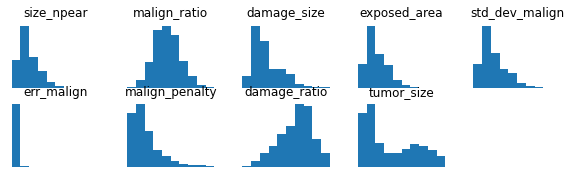

In [206]:
columns = train_data.columns
print(columns)
fig = plt.figure(figsize=(10,7))
for i in range(1, len(columns)):
    ax = fig.add_subplot(5, 5, i)
    ax.hist(train_data[columns[i]])
    ax.set_title(columns[i])
    ax.axis('off')
plt.show()

## Relationship

<Figure size 864x576 with 0 Axes>

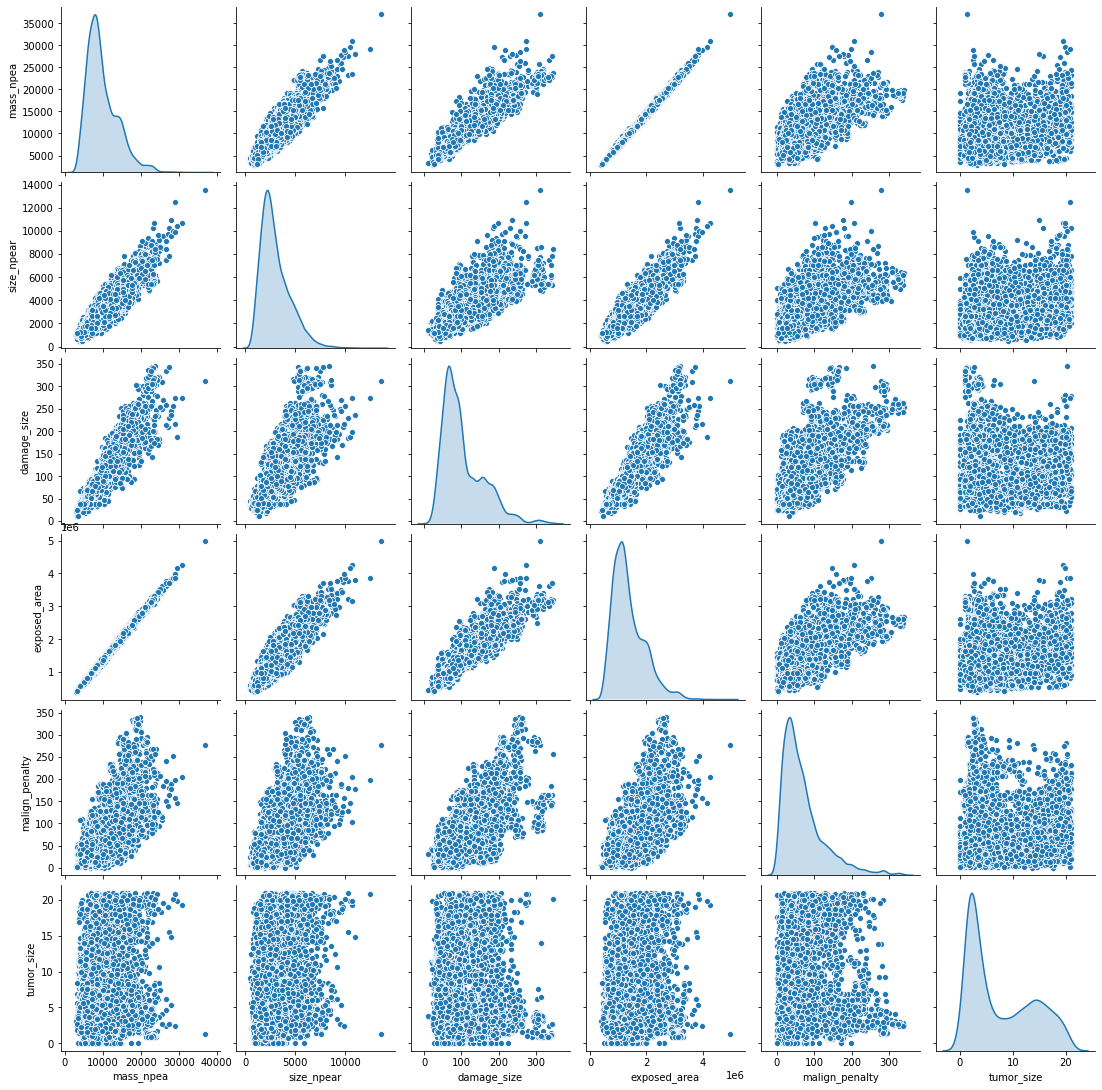

In [207]:
features = ['mass_npea', 'size_npear', 'damage_size','exposed_area','malign_penalty', 'tumor_size']

plt.figure(figsize=(12,8))
sns.pairplot(train_data[features], diag_kind='kde')
plt.show()

In [208]:
y = train_data['tumor_size'].values

quant_trans_y = quantile_transform(y.reshape(-1,1), n_quantiles=300, output_distribution='normal')

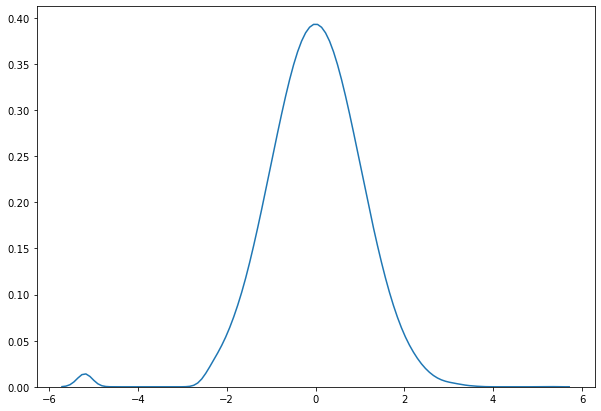

In [209]:
plt.figure(figsize=(10,7))
sns.distplot(quant_trans_y, kde=True, hist=False)
plt.show()

## Feature Scaling

### Polynomial Features

In [210]:
train_data['train_or_test'] = 0
test_data['train_or_test'] = 1

In [211]:
# Combining train and test data
combined_set = pd.concat([train_data, test_data])

features = ['mass_npea', 'size_npear', 'damage_size', 'exposed_area', 'malign_penalty']

X = combined_set[features]
# Invoking polynomial feature transform method with degree of 2 for two variables
poly_reg = PolynomialFeatures(degree=2, interaction_only=False)
X_poly = poly_reg.fit_transform(X)

# Converting array into a Dataframe
X_poly = pd.DataFrame(X_poly, index=combined_set.index)

X_poly = X_poly.drop([0], axis=1)
X_poly['train_or_test'] = combined_set['train_or_test']

In [222]:
xtrain_pf = X_poly.loc[X_poly['train_or_test'] == 0]
xtest_pf = X_poly.loc[X_poly['train_or_test'] == 1]

xtrain_pf = xtrain_pf.drop('train_or_test', axis=1)
xtest_pf = xtest_pf.drop('train_or_test', axis=1)

In [223]:
print(xtrain_pf.shape, xtest_pf.shape)

(9146, 20) (36584, 20)


In [119]:
# features = ['size_npear', 'damage_size','exposed_area','malign_penalty']
features = ['mass_npea', 'size_npear', 'malign_ratio', 'damage_size', 'exposed_area', 'std_dev_malign', 'err_malign', 'malign_penalty','damage_ratio']

In [231]:
# X = train_data[features]
# y = train_data.iloc[:, -1]
# X_test = test_data[features]


y = train_data['tumor_size']
X = xtrain_pf
X_test = xtest_pf

scaler = MinMaxScaler(feature_range=(0,1)).fit(X)

X_train_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

In [232]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain_pf.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=xtrain_pf.columns)

## Feature Selection

In [29]:
print(train_data.columns)

Index(['mass_npea', 'size_npear', 'malign_ratio', 'damage_size',
       'exposed_area', 'std_dev_malign', 'err_malign', 'malign_penalty',
       'damage_ratio', 'tumor_size'],
      dtype='object')


In [249]:
X_train_fs, X_test_fs, fs = RandomKBest(xtrain_pf, y, xtest_pf, mutual_info_regression, 18)

In [250]:
X_train_fs.shape

(9146, 18)

Feature 0: 0.179078
Feature 1: 0.154635
Feature 2: 0.240940
Feature 3: 0.189361
Feature 4: 0.206943
Feature 5: 0.181577
Feature 6: 0.172778
Feature 7: 0.237672
Feature 8: 0.205212
Feature 9: 0.197569
Feature 10: 0.159643
Feature 11: 0.209987
Feature 12: 0.174167
Feature 13: 0.195867
Feature 14: 0.240481
Feature 15: 0.235702
Feature 16: 0.214722
Feature 17: 0.192609
Feature 18: 0.200609
Feature 19: 0.194132


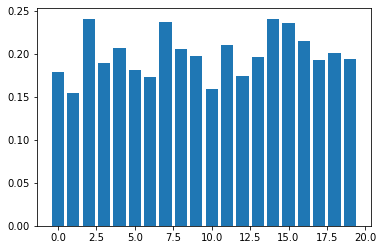

In [251]:
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [252]:
X_train_fs

array([[6.93090000e+03, 5.18298000e+01, 9.88829407e+05, ...,
        9.77783596e+11, 7.11957173e+07, 5.18400000e+03],
       [1.56357000e+04, 2.23550000e+02, 2.05842630e+06, ...,
        4.23711884e+12, 4.94022312e+08, 5.76000000e+04],
       [1.03762000e+04, 1.27337000e+02, 1.43467610e+06, ...,
        2.05829551e+12, 1.04731355e+08, 5.32900000e+03],
       ...,
       [8.08610000e+03, 7.85118000e+01, 1.13425661e+06, ...,
        1.28653805e+12, 1.47453359e+07, 1.69000000e+02],
       [1.44189000e+04, 8.40665000e+01, 1.95539782e+06, ...,
        3.82358062e+12, 7.62605148e+07, 1.52100000e+03],
       [6.85261000e+03, 5.13211000e+01, 9.55997647e+05, ...,
        9.13931500e+11, 2.67679341e+07, 7.84000000e+02]])

## Catboost Regressor

In [253]:
cat_param = {
    'iterations':800,
    'learning_rate' :0.15,
    'depth':6,
    'eval_metric' :'RMSE',
    'od_type' :'Iter',
    'metric_period' : 50,
    'od_wait' : 20,
    'random_seed' : 42,
    'bagging_temperature':0.2
}

cat_reg = CatBoostRegressor(**cat_param)

In [256]:
cat_reg.fit(X_train_fs, y)

0:	learn: 5.9090229	total: 4.67ms	remaining: 3.73s
50:	learn: 4.6295682	total: 207ms	remaining: 3.04s
100:	learn: 4.3294672	total: 403ms	remaining: 2.79s
150:	learn: 4.1090000	total: 606ms	remaining: 2.6s
200:	learn: 3.9458568	total: 800ms	remaining: 2.38s
250:	learn: 3.8128322	total: 1.01s	remaining: 2.21s
300:	learn: 3.6777931	total: 1.23s	remaining: 2.04s
350:	learn: 3.5669377	total: 1.46s	remaining: 1.87s
400:	learn: 3.4492559	total: 1.7s	remaining: 1.7s
450:	learn: 3.3638800	total: 1.94s	remaining: 1.5s
500:	learn: 3.2675628	total: 2.18s	remaining: 1.3s
550:	learn: 3.1884496	total: 2.45s	remaining: 1.11s
600:	learn: 3.1116340	total: 2.77s	remaining: 919ms
650:	learn: 3.0396300	total: 3.08s	remaining: 704ms
700:	learn: 2.9696282	total: 3.33s	remaining: 471ms
750:	learn: 2.9021058	total: 3.58s	remaining: 234ms
799:	learn: 2.8387832	total: 3.82s	remaining: 0us


In [257]:
predictions = cat_reg.predict(X_test_fs)

In [255]:
K = 15

kfold = KFold(n_splits=K, shuffle=True, random_state=101)

for i, (train_idx, test_idx) in enumerate(kfold.split(X_train_fs.values, y.values)):
    X_train, X_valid = X_train_fs.iloc[train_idx], X_train_fs.iloc[test_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
    
    
    print("-"* 20 + "Catboost Training" + "-"* 20)
    cat_reg.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=50,
            use_best_model=True,verbose=100)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [258]:
cat_reg.score(X_train_fs, y)

0.7824663824893698

In [245]:
y_preds = cat_reg.predict(X_valid)

In [246]:
err_val = np.sqrt(mean_squared_error(y_valid, y_preds))
print("Error value %0.3f " % err_val)

Error value 4.514 


In [247]:
predictions = cat_reg.predict(X_test_scaled_df)

In [259]:
predictions

array([5.35935513, 8.77052428, 2.15634216, ..., 6.24427017, 9.02648028,
       4.36653208])

## Predict the test data

In [260]:
final_preds = predictions

### Submission

In [261]:
final_df = pd.DataFrame({'tumor_size': final_preds}, index=test_data.index)

In [262]:
final_df.to_csv("./data/melanoma_cat_mir_01.csv", index=False)